# 6 Layer Neural Network

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import copy
import time

In [2]:
torch.manual_seed(10)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
device

device(type='mps')

In [4]:
mean = 0.5
std_dev = 0.25

In [5]:
transform1 = transforms.Compose([
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std_dev)
])
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std_dev)
])

In [6]:
train_data = torchvision.datasets.MNIST(
    root='../datasets',
    train = True,
    transform=transform2 #download is False in default
)

test_data = torchvision.datasets.MNIST(
    root='../datasets',
    train = False,
    transform=transform2
)

In [7]:
len(train_data)

60000

In [8]:
num_epochs = 50
batch_size = 256
learning_rate = 1e-3

In [9]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data,
    batch_size = batch_size,
    shuffle = True
)

In [10]:
len(train_loader)

235

In [11]:
def imshow(img, label):
    img = img * std_dev + mean  # unnormalize
    plt.imshow(img.reshape(img.shape[1],img.shape[2],img.shape[0]), cmap = 'gray')
    plt.title(f'Label {label}')
    plt.show()

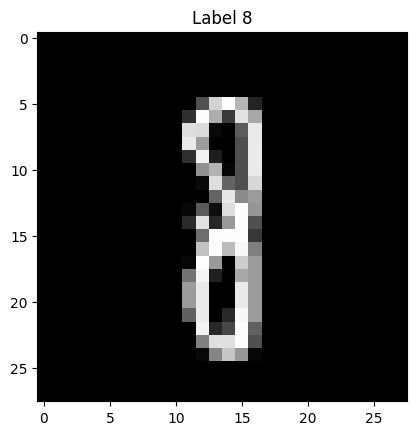

In [12]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(images[2],labels[2])

In [13]:
images.shape

torch.Size([256, 1, 28, 28])

In [14]:
class myResNet(nn.Module):
    def __init__(self) -> None:
        super(myResNet, self).__init__()

        self.conv1 = nn.Conv2d(1,4,5,1,'same') # 4, 28, 28
        # self.act1_1 = nn.ReLU() 
        self.norm1 = nn.BatchNorm2d(4)

        self.conv2 = nn.Conv2d(4,16,5,1,'same') # 16, 28, 28
        self.conv1to2 = nn.Conv2d(1,16,3,1,'same') # 16, 28, 28
        # self.act1_2 = nn.ReLU()
        self.norm2 = nn.BatchNorm2d(16)
            
        self.pool1 = nn.MaxPool2d(2, 2) # 16, 28, 28 --> 16, 14, 14
        
        self.conv3 = nn.Conv2d(16,64,3,1,'same') # 64, 14, 14
        self.conv1to3 = nn.Conv2d(1,64,3,2,1) # 64, 14, 14
        # self.act2_1 = nn.ReLU()
        self.norm3 = nn.BatchNorm2d(64)
            
        self.conv4 = nn.Conv2d(64,256,3,1,'same')  # 256, 14, 14
        self.conv1to4 = nn.Conv2d(1,256,3,2,1) # 256, 14, 14
        # self.act2_2 = nn.ReLU()
        self.norm4 = nn.BatchNorm2d(256)
        
        self.pool2 = nn.MaxPool2d(2, 2) # 256, 14, 14 --> 256, 7, 7

        self.flatten = nn.Flatten()

        self.lin5 = nn.Linear(256*7*7, 200)
        self.lin1to5 = nn.Linear(28*28*1, 200)
        # self.act4 = nn.ReLU()
        self.norm5 = nn.BatchNorm1d(200)

        self.lin6 = nn.Linear(200, 85)
        self.lin1to6 = nn.Linear(28*28*1, 85)
        # self.act5 = nn.ReLU()
        self.norm6 = nn.BatchNorm1d(85)

        self.lin_fin = nn.Linear(85,10)
    
    def forward(self, x):
        x_temp1 = x
        x = self.norm1(torch.relu(self.conv1(x)))
        
        x_temp2 = x
        x = self.norm2(torch.relu(self.conv2(x)+self.conv1to2(x_temp1))) # Residual

        x_temp3 = x
        x = self.pool1(x)

        x = self.norm3(torch.relu(self.conv3(x)+self.conv1to3(x_temp1)))

        x_temp4 = x
        x = self.norm4(torch.relu(self.conv4(x)+self.conv1to4(x_temp1))) # Residual

        x_temp5 = x
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.norm5(torch.relu(self.lin5(x)+self.lin1to5(self.flatten(x_temp1))))

        x_temp6 = x
        x = self.norm6(torch.relu(self.lin6(x)+self.lin1to6(self.flatten(x_temp1))))
        x = self.lin_fin(x)
        return(x)

In [15]:
resnet = myResNet().to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 9, gamma = 0.5)

In [19]:
summary(resnet, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]             104
       BatchNorm2d-2            [-1, 4, 28, 28]               8
            Conv2d-3           [-1, 16, 28, 28]           1,616
            Conv2d-4           [-1, 16, 28, 28]             160
       BatchNorm2d-5           [-1, 16, 28, 28]              32
         MaxPool2d-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 64, 14, 14]           9,280
            Conv2d-8           [-1, 64, 14, 14]             640
       BatchNorm2d-9           [-1, 64, 14, 14]             128
           Conv2d-10          [-1, 256, 14, 14]         147,712
           Conv2d-11          [-1, 256, 14, 14]           2,560
      BatchNorm2d-12          [-1, 256, 14, 14]             512
        MaxPool2d-13            [-1, 256, 7, 7]               0
          Flatten-14                [-1

In [17]:
best_weights = copy.deepcopy(resnet.state_dict())
max = 0
val_acc = 0
train_acc = 0
for epoch in range(num_epochs):
    resnet.train()
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        preds = resnet.forward(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    print(f'Epoch {epoch+1}/{num_epochs}; Loss = {loss.item():.6f}; LR = {scheduler.get_last_lr()}')
    with torch.no_grad():
        n_samples = 0
        n_correct = 0
        resnet.eval()
        for images, labels in test_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = resnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        val_acc = n_correct/n_samples * 100

        if (max <= (n_correct/n_samples * 100)):
            print('SAVED MODEL WEIGHTS')
            max = val_acc
            best_weights = copy.deepcopy(resnet.state_dict())

        n_samples = 0
        n_correct = 0
        
        for images, labels in train_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = resnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        train_acc = n_correct/n_samples * 100
    
    print(f'Train Accuracy: {train_acc:.2f}%')
    print(f'Dev Accuracy: {val_acc:.2f}%')
    print("-"*20)

Epoch 1/50; Loss = 0.117283; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 98.65%
Dev Accuracy: 98.13%
--------------------
Epoch 2/50; Loss = 0.014636; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.33%
Dev Accuracy: 98.86%
--------------------
Epoch 3/50; Loss = 0.010203; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.59%
Dev Accuracy: 99.00%
--------------------
Epoch 4/50; Loss = 0.044522; LR = [0.001]
Train Accuracy: 99.52%
Dev Accuracy: 98.75%
--------------------
Epoch 5/50; Loss = 0.057145; LR = [0.001]
Train Accuracy: 99.54%
Dev Accuracy: 98.93%
--------------------
Epoch 6/50; Loss = 0.001099; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.87%
Dev Accuracy: 99.10%
--------------------
Epoch 7/50; Loss = 0.002718; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.75%
Dev Accuracy: 99.14%
--------------------
Epoch 8/50; Loss = 0.001473; LR = [0.001]
Train Accuracy: 99.79%
Dev Accuracy: 99.06%
--------------------
Epoch 9/50; Loss = 0.011545; LR = [0.0005]
T

In [23]:
# resnet.load_state_dict(best_weights)
# torch.save(resnet, 'models/fully_nested_resnet_mnist.pt')

# Fully Connected ResNet (DenseNet) with Norm

In [25]:
class FullNestedResNet(nn.Module):
    def __init__(self) -> None:
        super(FullNestedResNet, self).__init__()

        self.conv1 = nn.Conv2d(1,4,5,1,'same') # 4, 28, 28
        # self.act1 = nn.ReLU() 
        self.norm1 = nn.BatchNorm2d(4)

        self.conv2 = nn.Conv2d(4,16,5,1,'same') # 16, 28, 28
        self.conv1to2 = nn.Conv2d(1,16,3,1,'same') # 16, 28, 28
        self.norm1to2 = nn.BatchNorm2d(16)
        # self.act2 = nn.ReLU()
        self.norm2 = nn.BatchNorm2d(16)
            
        self.pool1 = nn.MaxPool2d(2, 2) # 16, 28, 28 --> 16, 14, 14
        
        self.conv3 = nn.Conv2d(16,64,3,1,'same') # 64, 14, 14
        self.conv1to3 = nn.Conv2d(1,64,3,2,1) # 64, 14, 14
        self.norm1to3 = nn.BatchNorm2d(64) # 64, 14, 14

        self.conv2to3 = nn.Conv2d(4,64,3,2,1)
        self.norm2to3 = nn.BatchNorm2d(64)

        # self.act3 = nn.ReLU()
        self.norm3 = nn.BatchNorm2d(64)
            
        self.conv4 = nn.Conv2d(64,256,3,1,'same')  # 256, 14, 14
        self.conv1to4 = nn.Conv2d(1,256,3,2,1) # 256, 14, 14
        self.norm1to4 = nn.BatchNorm2d(256)

        self.conv2to4 = nn.Conv2d(4,256,3,2,1) # 256, 14, 14
        self.norm2to4 = nn.BatchNorm2d(256)

        self.conv3to4 = nn.Conv2d(16,256,3,1,1) # 256, 14, 14 # Stride = 1
        self.norm3to4 = nn.BatchNorm2d(256)

        # self.act4 = nn.ReLU()
        self.norm4 = nn.BatchNorm2d(256)
        
        self.pool2 = nn.MaxPool2d(2, 2) # 256, 14, 14 --> 256, 7, 7

        self.flatten = nn.Flatten()

        self.lin5 = nn.Linear(256*7*7, 200)
        self.lin1to5 = nn.Linear(28*28*1, 200)
        self.norm1to5 = nn.BatchNorm1d(200)

        self.lin2to5 = nn.Linear(28*28*4, 200)
        self.norm2to5 = nn.BatchNorm1d(200)

        self.lin3to5 = nn.Linear(14*14*16, 200)
        self.norm3to5 = nn.BatchNorm1d(200)

        self.lin4to5 = nn.Linear(14*14*64, 200)
        self.norm4to5 = nn.BatchNorm1d(200)
        # self.act4 = nn.ReLU()
        self.norm5 = nn.BatchNorm1d(200)

        self.lin6 = nn.Linear(200, 85)
        self.lin1to6 = nn.Linear(28*28*1, 85)
        self.norm1to6 = nn.BatchNorm1d(85)

        self.lin2to6 = nn.Linear(28*28*4, 85)
        self.norm2to6 = nn.BatchNorm1d(85)

        self.lin3to6 = nn.Linear(14*14*16, 85)
        self.norm3to6 = nn.BatchNorm1d(85)

        self.lin4to6 = nn.Linear(14*14*64, 85)
        self.norm4to6 = nn.BatchNorm1d(85)

        self.lin5to6 = nn.Linear(7*7*256, 85)
        self.norm5to6 = nn.BatchNorm1d(85)
        # self.act5 = nn.ReLU()
        self.norm6 = nn.BatchNorm1d(85)

        self.lin_fin = nn.Linear(85,10)
    
    def forward(self, x):
        x_temp1 = x
        x = self.norm1(torch.relu(self.conv1(x)))
        
        x_temp2 = x
        x = self.conv2(x) + self.norm1to2(self.conv1to2(x_temp1))
        x = self.norm2(torch.relu(x)) # Residual

        x = self.pool1(x)
        x_temp3 = x

        x = self.conv3(x) + self.norm1to3(self.conv1to3(x_temp1)) + self.norm2to3(self.conv2to3(x_temp2))
        x = self.norm3(torch.relu(x))

        x_temp4 = x

        x = self.conv4(x) + self.norm1to4(self.conv1to4(x_temp1)) + self.norm2to4(self.conv2to4(x_temp2)) + self.norm3to4(self.conv3to4(x_temp3))
        x = self.norm4(torch.relu(x)) # Residual

        x = self.pool2(x)
        x_temp5 = x

        x = self.flatten(x)

        x = self.lin5(x) + self.norm1to5(self.lin1to5(self.flatten(x_temp1))) + self.norm2to5(self.lin2to5(self.flatten(x_temp2))) + self.norm3to5(self.lin3to5(self.flatten(x_temp3))) + self.norm4to5(self.lin4to5(self.flatten(x_temp4)))
        x = self.norm5(torch.relu(x))

        x = self.lin6(x) + self.norm1to6(self.lin1to6(self.flatten(x_temp1))) + self.norm2to6(self.lin2to6(self.flatten(x_temp2))) + self.norm3to6(self.lin3to6(self.flatten(x_temp3))) + self.norm4to6(self.lin4to6(self.flatten(x_temp4))) + self.norm5to6(self.lin5to6(self.flatten(x_temp5)))
        x = self.norm6(torch.relu(x))
        x = self.lin_fin(x)
        return(x)

In [26]:
fullresnet = FullNestedResNet().to(device)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fullresnet.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 9, gamma = 0.5)

In [36]:
summary(fullresnet, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]             104
       BatchNorm2d-2            [-1, 4, 28, 28]               8
            Conv2d-3           [-1, 16, 28, 28]           1,616
            Conv2d-4           [-1, 16, 28, 28]             160
       BatchNorm2d-5           [-1, 16, 28, 28]              32
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]           9,280
            Conv2d-9           [-1, 64, 14, 14]             640
      BatchNorm2d-10           [-1, 64, 14, 14]             128
           Conv2d-11           [-1, 64, 14, 14]           2,368
      BatchNorm2d-12           [-1, 64, 14, 14]             128
      BatchNorm2d-13           [-1, 64, 14, 14]             128
           Conv2d-14          [-1, 256,

In [28]:
best_weights = copy.deepcopy(fullresnet.state_dict())
max = 0
val_acc = 0
train_acc = 0
tic = time.time()
for epoch in range(num_epochs):
    fullresnet.train()
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        preds = fullresnet.forward(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    print(f'Epoch {epoch+1}/{num_epochs}; Loss = {loss.item():.6f}; LR = {scheduler.get_last_lr()}')
    with torch.no_grad():
        n_samples = 0
        n_correct = 0
        fullresnet.eval()
        for images, labels in test_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = fullresnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        val_acc = n_correct/n_samples * 100

        if (max <= (n_correct/n_samples * 100)):
            print('SAVED MODEL WEIGHTS')
            max = val_acc
            best_weights = copy.deepcopy(fullresnet.state_dict())

        n_samples = 0
        n_correct = 0
        
        for images, labels in train_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = fullresnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        train_acc = n_correct/n_samples * 100
    
    print(f'Train Accuracy: {train_acc:.2f}%')
    print(f'Dev Accuracy: {val_acc:.2f}%')
    print("-"*20)
print('Finished Training!')
print(f'Time Taken = {(time.time()-tic)//60}m {(time.time()-tic)%60}s')

Epoch 1/50; Loss = 0.020829; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.37%
Dev Accuracy: 98.95%
--------------------
Epoch 2/50; Loss = 0.067783; LR = [0.001]
Train Accuracy: 99.62%
Dev Accuracy: 98.84%
--------------------
Epoch 3/50; Loss = 0.004471; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.86%
Dev Accuracy: 98.98%
--------------------
Epoch 4/50; Loss = 0.009092; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.90%
Dev Accuracy: 98.98%
--------------------
Epoch 5/50; Loss = 0.034807; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.94%
Dev Accuracy: 99.13%
--------------------
Epoch 6/50; Loss = 0.002638; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.96%
Dev Accuracy: 99.17%
--------------------
Epoch 7/50; Loss = 0.001619; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.91%
Dev Accuracy: 99.22%
--------------------
Epoch 8/50; Loss = 0.001177; LR = [0.001]
Train Accuracy: 99.77%
Dev Accuracy: 99.05%
--------------------
Epoch 9/50; Loss = 0.026

Time taken by connecting everything is also much LARGER and also **no improvement** from just connecting the input to every point

# Start connected longer ResNet

In [21]:
class myBigResNet(nn.Module):
    def __init__(self) -> None:
        super(myBigResNet, self).__init__()

        self.conv1 = nn.Conv2d(1,4,5,1,'same') # 4, 28, 28
        # self.act1_1 = nn.ReLU() 
        self.norm1 = nn.BatchNorm2d(4)

        self.conv2 = nn.Conv2d(4,16,5,1,'same') # 16, 28, 28
        self.conv1to2 = nn.Conv2d(1,16,3,1,'same') # 16, 28, 28
        # self.act1_2 = nn.ReLU()
        self.norm2 = nn.BatchNorm2d(16)
            
        self.pool1 = nn.MaxPool2d(2, 2) # 16, 28, 28 --> 16, 14, 14
        
        self.conv3 = nn.Conv2d(16,64,3,1,'same') # 64, 14, 14
        self.conv1to3 = nn.Conv2d(1,64,3,2,1) # 64, 14, 14
        # self.act2_1 = nn.ReLU()
        self.norm3 = nn.BatchNorm2d(64)
            
        self.conv4 = nn.Conv2d(64,256,3,1,'same')  # 256, 14, 14
        self.conv1to4 = nn.Conv2d(1,256,3,2,1) # 256, 14, 14
        # self.act2_2 = nn.ReLU()
        self.norm4 = nn.BatchNorm2d(256)
        
        self.pool2 = nn.MaxPool2d(2, 2) # 256, 14, 14 --> 256, 7, 7

        self.conv5 = nn.Conv2d(256,512,5,1,'same') # 512, 7, 7
        self.conv1to5 = nn.Conv2d(1,512,3,4,1) # 1024, 7, 7
        # self.act1_1 = nn.ReLU() 
        self.norm5 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(512,1024,5,1,'same') # 1024, 7, 7
        self.conv1to6 = nn.Conv2d(1,1024,3,4,1) # 1024, 7, 7
        # self.act1_2 = nn.ReLU()
        self.norm6 = nn.BatchNorm2d(1024)
            
        self.pool3 = nn.MaxPool2d(2, 2) # 1024, 7, 7 --> 1024, 3, 3

        self.flatten = nn.Flatten()

        self.lin7 = nn.Linear(1024*3*3, 1024)
        self.lin1to7 = nn.Linear(28*28*1, 1024)
        # self.act4 = nn.ReLU()
        self.norm7 = nn.BatchNorm1d(1024)

        self.lin8 = nn.Linear(1024, 512)
        self.lin1to8 = nn.Linear(28*28*1, 512)
        # self.act5 = nn.ReLU()
        self.norm8 = nn.BatchNorm1d(512)

        self.lin9 = nn.Linear(512, 128)
        self.lin1to9 = nn.Linear(28*28*1, 128)
        # self.act5 = nn.ReLU()
        self.norm9 = nn.BatchNorm1d(128)

        self.lin10 = nn.Linear(128, 84)
        self.lin1to10 = nn.Linear(28*28*1, 84)
        # self.act5 = nn.ReLU()
        self.norm10 = nn.BatchNorm1d(84)

        self.lin_fin = nn.Linear(84,10)
    
    def forward(self, x):
        x_temp1 = x
        x = self.norm1(torch.relu(self.conv1(x)))
        x = self.norm2(torch.relu(self.conv2(x)+self.conv1to2(x_temp1))) # Residual
        x = self.pool1(x)

        x = self.norm3(torch.relu(self.conv3(x)+self.conv1to3(x_temp1)))
        x = self.norm4(torch.relu(self.conv4(x)+self.conv1to4(x_temp1))) # Residual
        x = self.pool2(x)

        x = self.norm5(torch.relu(self.conv5(x)+self.conv1to5(x_temp1)))
        x = self.norm6(torch.relu(self.conv6(x)+self.conv1to6(x_temp1))) # Residual
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.norm7(torch.relu(self.lin7(x)+self.lin1to7(self.flatten(x_temp1))))
        x = self.norm8(torch.relu(self.lin8(x)+self.lin1to8(self.flatten(x_temp1))))
        x = self.norm9(torch.relu(self.lin9(x)+self.lin1to9(self.flatten(x_temp1))))
        x = self.norm10(torch.relu(self.lin10(x)+self.lin1to10(self.flatten(x_temp1))))

        x = self.lin_fin(x)
        return(x)

In [22]:
bigresnet = myBigResNet().to(device)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bigresnet.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 9, gamma = 0.5)

In [16]:
summary(bigresnet, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]             104
       BatchNorm2d-2            [-1, 4, 28, 28]               8
            Conv2d-3           [-1, 16, 28, 28]           1,616
            Conv2d-4           [-1, 16, 28, 28]             160
       BatchNorm2d-5           [-1, 16, 28, 28]              32
         MaxPool2d-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 64, 14, 14]           9,280
            Conv2d-8           [-1, 64, 14, 14]             640
       BatchNorm2d-9           [-1, 64, 14, 14]             128
           Conv2d-10          [-1, 256, 14, 14]         147,712
           Conv2d-11          [-1, 256, 14, 14]           2,560
      BatchNorm2d-12          [-1, 256, 14, 14]             512
        MaxPool2d-13            [-1, 256, 7, 7]               0
           Conv2d-14            [-1, 51

In [24]:
best_weights = copy.deepcopy(bigresnet.state_dict())
max = 0
val_acc = 0
train_acc = 0
tic = time.time()
for epoch in range(num_epochs):
    bigresnet.train()
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        preds = bigresnet.forward(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    print(f'Epoch {epoch+1}/{num_epochs}; Loss = {loss.item():.6f}; LR = {scheduler.get_last_lr()}')
    with torch.no_grad():
        n_samples = 0
        n_correct = 0
        bigresnet.eval()
        for images, labels in test_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = bigresnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        val_acc = n_correct/n_samples * 100

        if (max <= (n_correct/n_samples * 100)):
            print('SAVED MODEL WEIGHTS')
            max = val_acc
            best_weights = copy.deepcopy(bigresnet.state_dict())

        n_samples = 0
        n_correct = 0
        
        for images, labels in train_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = bigresnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        train_acc = n_correct/n_samples * 100
    
    print(f'Train Accuracy: {train_acc:.2f}%')
    print(f'Dev Accuracy: {val_acc:.2f}%')
    print("-"*20)
print('Finished Training!')
print(f'Time Taken = {(time.time()-tic)//60}m {(time.time()-tic)%60}s')

Epoch 1/50; Loss = 0.052776; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 98.00%
Dev Accuracy: 97.77%
--------------------
Epoch 2/50; Loss = 0.020049; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.18%
Dev Accuracy: 98.74%
--------------------
Epoch 3/50; Loss = 0.028687; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.66%
Dev Accuracy: 99.08%
--------------------
Epoch 4/50; Loss = 0.008632; LR = [0.001]
Train Accuracy: 99.59%
Dev Accuracy: 98.99%
--------------------
Epoch 5/50; Loss = 0.008108; LR = [0.001]
Train Accuracy: 99.44%
Dev Accuracy: 98.84%
--------------------
Epoch 6/50; Loss = 0.014051; LR = [0.001]
Train Accuracy: 99.00%
Dev Accuracy: 98.30%
--------------------
Epoch 7/50; Loss = 0.073416; LR = [0.001]
SAVED MODEL WEIGHTS
Train Accuracy: 99.72%
Dev Accuracy: 99.11%
--------------------
Epoch 8/50; Loss = 0.002062; LR = [0.001]
Train Accuracy: 99.76%
Dev Accuracy: 98.91%
--------------------
Epoch 9/50; Loss = 0.001346; LR = [0.0005]
Train Accuracy: 99.75

In [20]:
torch.has_mps

True